# TP2

Code pour exécuter le code 

In [26]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import h5py

# Charger le modèle
model = tf.keras.models.load_model('model-B.h5')

# Charger les noms des classes depuis le fichier HDF5
with h5py.File('model-B.h5', 'r') as f:
    class_names = [name.decode('utf-8') for name in f.attrs['class_names']]

# Dictionnaire de traduction de l'italien au français
translation_dict = {
    'Fursuit': 'Fursuit',
    'scoiattolo': 'écureuil',
    'ragno': 'araignée',
    'pecora': 'mouton',
    'mucca': 'vache',
    'gatto': 'chat',
    'gallina': 'poule',
    'farfalle': 'papillon',
    'elefante': 'éléphant',
    'cavallo': 'cheval',
    'cane': 'chien',
}

def traduire_au_francais(name):
    return translation_dict.get(name, name)  # Retourne le nom original s'il n'y a pas de traduction

def predire_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Faire des prédictions
    predictions = model.predict(img_array)
    predictions = predictions[0]
    
    # Décider si c'est un fursuit ou un animal
    class_idx = np.argmax(predictions)
    
    if class_names[class_idx] == 'Fursuit':
        print('Fursuit : oui')
        print('Fursuit : -')
    else:
        print('Fursuit : non')
        # Traduire le nom de l’espèce en français
        nom_francais = traduire_au_francais(class_names[class_idx])
        print("Espèce :", nom_francais)
        

# Exemple de prédiction
predire_image('chien1.jpeg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Fursuit : non
Espèce : chien


### Réseau A

| Composant                | Description                                                             |
|--------------------------|-------------------------------------------------------------------------|
| **Taille de l'image**    | 64 x 64                                                                 |
| **Taille du batch**      | 1100                                                                    |
| **Époques d'entraînement** | 5                                                                     |

Found 26379 files belonging to 11 classes.
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.1612 - loss: 2.3229 - val_accuracy: 0.2318 - val_loss: 2.2886
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2274 - loss: 2.1878 - val_accuracy: 0.2845 - val_loss: 2.0734
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2811 - loss: 2.0453 - val_accuracy: 0.3245 - val_loss: 1.9876
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.3125 - loss: 1.9622 - val_accuracy: 0.3882 - val_loss: 1.8880
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.3535 - loss: 1.8794 - val_accuracy: 0.4231 - val_loss: 1.8136


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 890ms/step


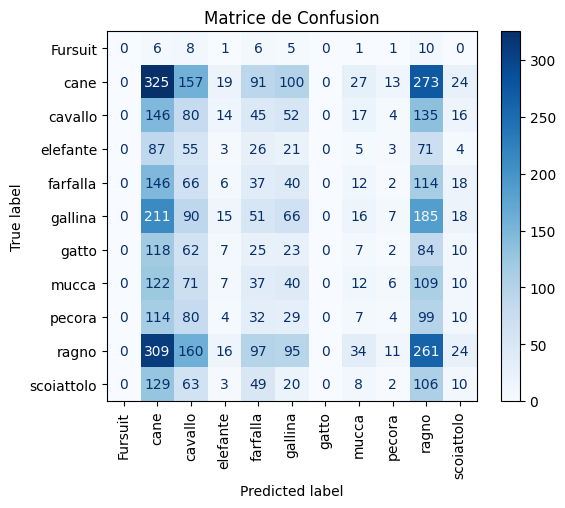

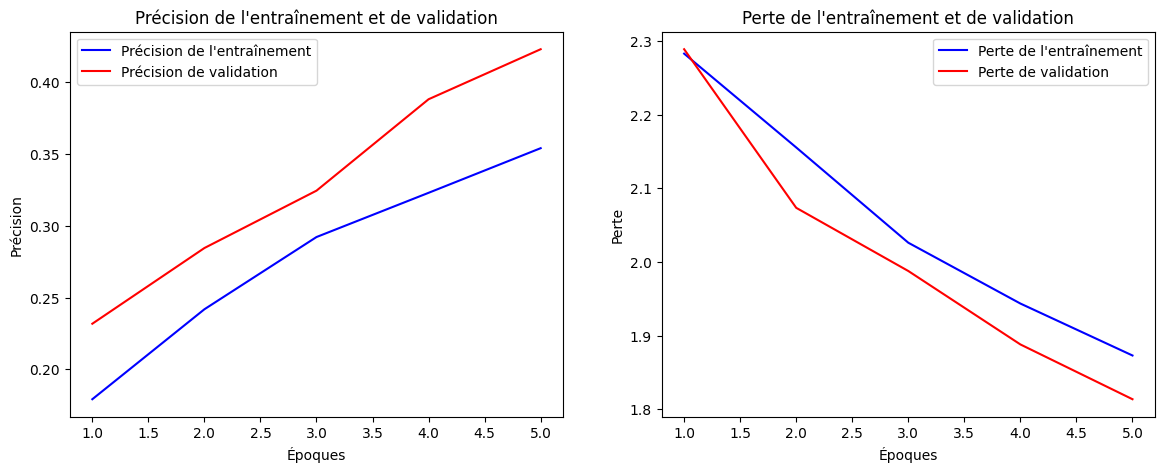

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=1100,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle avec Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la première couche de convolution
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la deuxième couche de convolution
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la troisième couche de convolution
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

# Sauvegarder le modèle
model1.save('model-A.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('model-A.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Évaluation du modèle
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
val_predictions = np.argmax(model1.predict(val_dataset), axis=-1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model B

| Composant                | Description                                                             |
|--------------------------|-------------------------------------------------------------------------|
| **Taille de l'image**    | 64 x 64                                                                 |
| **Taille du batch**      | 32                                                                      |
| **Époques d'entraînement** | 45                                                                   |



Found 26379 files belonging to 11 classes.
Epoch 1/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 144s 200ms/step - accuracy: 0.2250 - loss: 2.1955 - val_accuracy: 0.3767 - val_loss: 1.8106
Epoch 2/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 126s 191ms/step - accuracy: 0.3761 - loss: 1.8151 - val_accuracy: 0.4687 - val_loss: 1.5589
Epoch 3/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 128s 194ms/step - accuracy: 0.4415 - loss: 1.6224 - val_accuracy: 0.5275 - val_loss: 1.3976
Epoch 4/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 127s 192ms/step - accuracy: 0.4954 - loss: 1.4692 - val_accuracy: 0.5661 - val_loss: 1.2849
Epoch 5/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 131s 198ms/step - accuracy: 0.5258 - loss: 1.3812 - val_accuracy: 0.6024 - val_loss: 1.1974
Epoch 6/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 153s 215ms/step - accuracy: 0.5557 - loss: 1.3199 - val_accuracy: 0.5925 - val_loss: 1.1940
Epoch 7/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 132s 199ms/step - accuracy: 0.5817 - loss: 1.2401 - val_accuracy: 0.6359 - val_loss: 1.0856
Epoch 8/45
660/660 ━━━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step


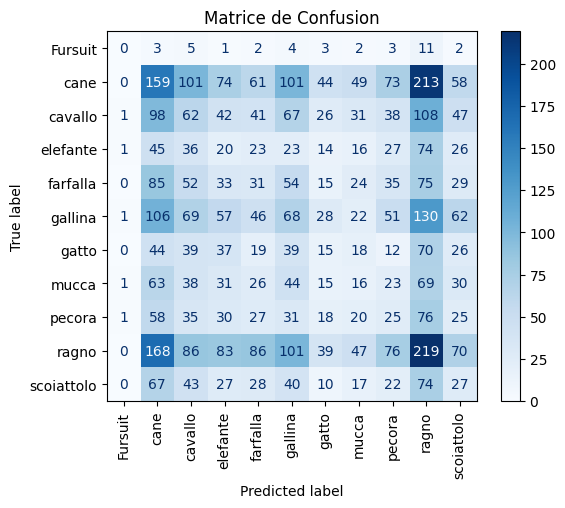

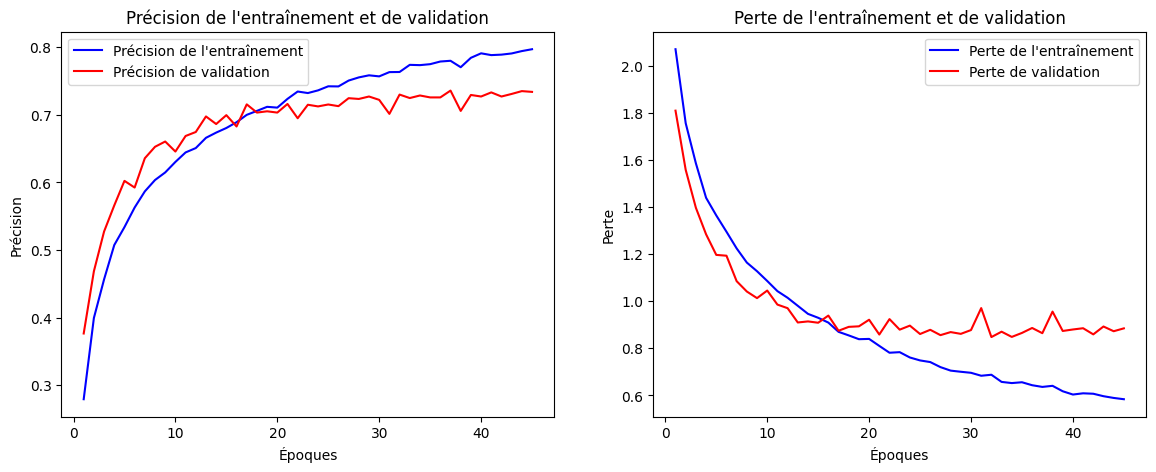

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=32,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = 11

# Révision de l'architecture du modèle avec Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la première couche de convolution
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la deuxième couche de convolution
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la troisième couche de convolution
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(dataset)
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=45
)

# Sauvegarder le modèle
model1.save('model-B.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('model-B.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Évaluation du modèle
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
val_predictions = np.argmax(model1.predict(val_dataset), axis=-1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model C

| Hyperparamètre                   | Valeur                                  |
|---------------------------------|-----------------------------------------|
| **Taille de l'image**            | 128x128                                  |
| **Taille du batch**              | 16                                       |
| **Nombre d'époques**             | 36                                       |


Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 492s 364ms/step - accuracy: 0.2161 - loss: 2.2178 - val_accuracy: 0.3900 - val_loss: 1.8030
Epoch 2/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 467s 337ms/step - accuracy: 0.3543 - loss: 1.8543 - val_accuracy: 0.4777 - val_loss: 1.5423
Epoch 3/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 485s 367ms/step - accuracy: 0.4362 - loss: 1.6343 - val_accuracy: 0.5276 - val_loss: 1.4654
Epoch 4/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 481s 364ms/step - accuracy: 0.4834 - loss: 1.4982 - val_accuracy: 0.5630 - val_loss: 1.3001
Epoch 5/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 12401s 9s/step - accuracy: 0.5121 - loss: 1.4019 - val_accuracy: 0.5979 - val_loss: 1.2291
Epoch 6/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 585s 443ms/step - accuracy: 0.5475 - loss: 1.3177 - val_accuracy: 0.6004 - val_loss: 1.1852
Epoch 7/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 552s 418ms/step - accuracy: 0.5577 - loss: 1.2812 - val_accuracy: 0.6155 - val_loss: 1.1550
Epoch 8/36
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 528s 391ms/step - acc

330/330 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step


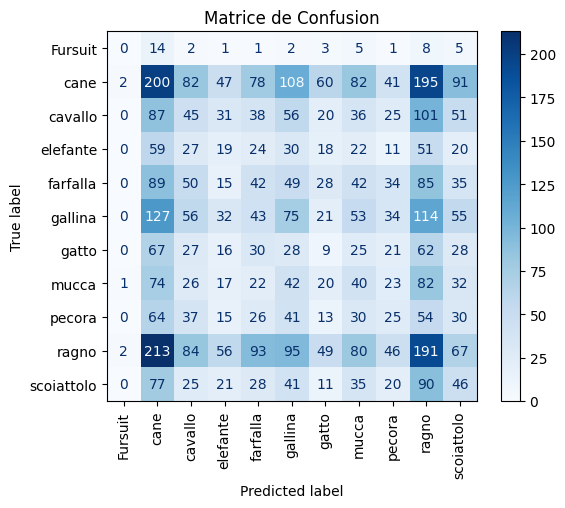

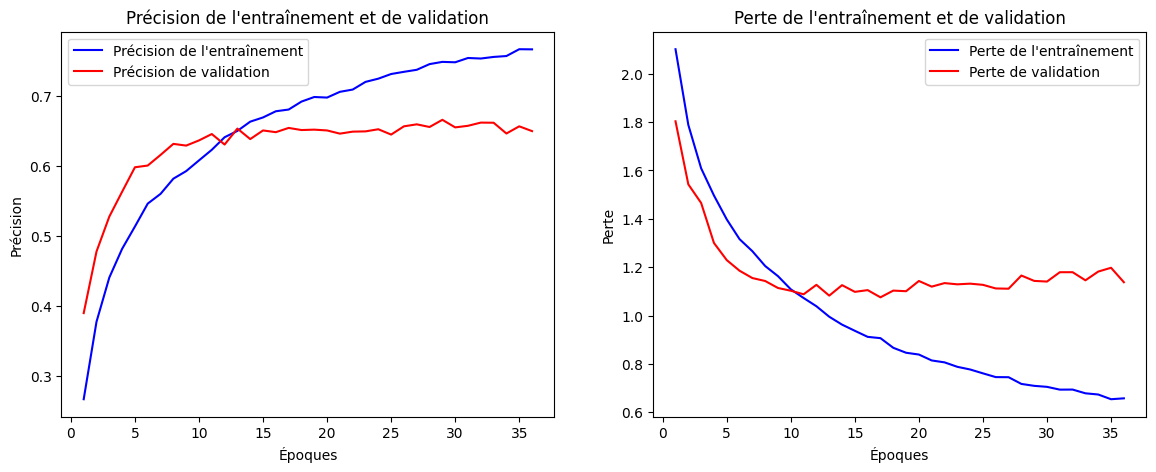

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    # Convertir l'image en niveaux de gris
    image = tf.image.rgb_to_grayscale(image)
    # Redimensionner l'image
    image = tf.image.resize(image, [128, 128])
    # Normaliser les valeurs de pixel entre 0 et 1
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(128, 128),
    batch_size=16,  # Changement du batch size à 64
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle avec Dropout pour les images en niveaux de gris
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),  # Notez l'entrée (128, 128, 1) pour les images en niveaux de gris
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la première couche de convolution
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la deuxième couche de convolution
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la troisième couche de convolution
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=36  # Changement du nombre d'époques à 36
)

# Sauvegarder le modèle
model1.save('model-C.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('model-C.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Évaluation du modèle
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
val_predictions = np.argmax(model1.predict(val_dataset), axis=-1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()
